In [1]:
import pandas as pd, networkx as nx, sys, os, numpy as np
import nbimporter
sys.path.append('scripts')
from mappy_stuff import *
import geopandas as gpd
import seaborn as sns
import collections
import matplotlib.pyplot as plt

In [2]:
city_dict = {city : None for city in ['bergen', 'trondheim', 'oslo', 'portland', 'washington']}
for i in city_dict:
    stations, amenities = load_city_amenities_and_bike_stations(i)
    city_dict[i] = CityLineGraph(i)
    city_dict[i].read_graph()
    city_dict[i].feats = city_dict[i].feats.drop(columns = ['from', 'to'])
    ### limit lg to be biggest connected component
    G = city_dict[i].lg
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    city_dict[i].lg = nx.Graph(G0)

100%|██████████| 24/24 [00:05<00:00,  4.20it/s]


Self Loops Removed


100%|██████████| 18/18 [00:01<00:00, 10.04it/s]


Self Loops Removed


100%|██████████| 24/24 [00:12<00:00,  1.98it/s]


Self Loops Removed


100%|██████████| 24/24 [00:03<00:00,  6.27it/s]
mappy_stuff.ipynb:20: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  "from shapely.geometry import LineString, Polygon\n",


Self Loops Removed


100%|██████████| 24/24 [00:37<00:00,  1.57s/it]


Self Loops Removed


In [3]:
common_df = pd.DataFrame()

for city in city_dict:
    tmp = city_dict[city].feats.astype(bool).drop(columns = ['population', 'price_per_sqm', 'station', 'station_id'])
    tmp['sum'] = tmp.sum(axis = 1)
    tmp['city'] = city
    tmp['city'] = tmp['city'].str.capitalize()
    tmp = tmp[['city', 'sum']]
    common_df = pd.concat([common_df, tmp])
common_df = common_df.sort_values(by = 'city', ascending = True)

common_df = common_df.reset_index(drop = True)
common_df.columns = [i.capitalize() for i in common_df.columns]

In [4]:
city_color_map = {'Bergen' : 'blue', 'Trondheim' : 'red', 'Oslo' : 'green', 'Portland' : 'purple', 'Washington' : 'orange'}

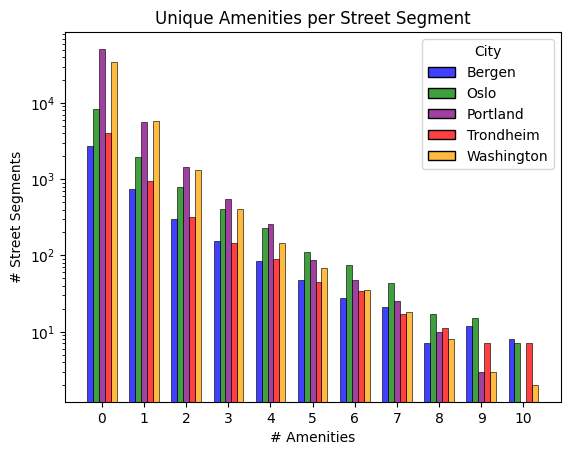

In [5]:
g = sns.histplot(data = common_df.query('11 > Sum'), x = 'Sum', hue = 'City', multiple="dodge", discrete=True, shrink = 0.7, palette = city_color_map)
g.set_yscale('log')
# plt.xlim(1, 10)
plt.xticks(np.arange(0, 11, 1))
plt.xlabel('# Amenities')
plt.ylabel('# Street Segments')
plt.title('Unique Amenities per Street Segment')
# plt.legend(title = 'City')

plt.show()

In [8]:
mean_price_per_sqm

,city,price_per_sqm
0,Bergen,7.566115e+03
1,Oslo,1.030151e+04
2,Portland,7.928554e+03
3,Trondheim,6.599377e+03
4,Washington,inf


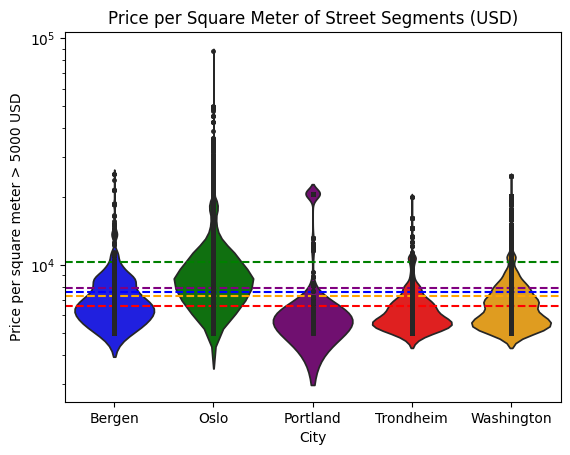

In [ ]:
common_df = pd.DataFrame()
for city in city_dict:
    tmp = city_dict[city].feats.drop(columns = ['station', 'station_id'])
    tmp['sum'] = tmp.sum(axis = 1)
    tmp['city'] = city
    tmp['city'] = tmp['city'].str.capitalize()
    if city in ['bergen', 'trondheim', 'oslo']:
        tmp['price_per_sqm'] = tmp.price_per_sqm.apply(lambda x: x/11.06)
    common_df = pd.concat([common_df, tmp])
common_df = common_df.sort_values(by = 'city', ascending = True)

inf = float('inf')
smol = common_df[['price_per_sqm', 'city', 'population']].fillna(0).query('price_per_sqm > 5000 & price_per_sqm < @inf')

### add mean price per sqm to each city
mean_price_per_sqm = smol.groupby('city').price_per_sqm.mean().reset_index()

g = sns.violinplot(data = smol.reset_index(), y = 'price_per_sqm', x='city', common_norm = False, inner='point', hue = 'city', palette=city_color_map)

# plt.ylim(80, 10000)
g.set_yscale('log')

### add mean price per sqm to each city
for i in range(len(mean_price_per_sqm)):
    plt.axhline(mean_price_per_sqm.price_per_sqm[i], color = city_color_map[mean_price_per_sqm.city[i]], linestyle = 'dashed')


plt.ylabel('Price per square meter > 5000 USD')
plt.xlabel('City')
plt.title('Price per Square Meter of Street Segments (USD)')

plt.show()

In [10]:
mean_price_per_sqm

,city,price_per_sqm
0,Bergen,7566.115256
1,Oslo,10301.512144
2,Portland,7928.553903
3,Trondheim,6599.377242
4,Washington,7270.694233


In [13]:
import pandas as pd
df = pd.read_csv('data/listings/clean/listings.csv')

In [14]:
### get df with price == nan
nan_price = df[df.price_per_sqm.isna()]

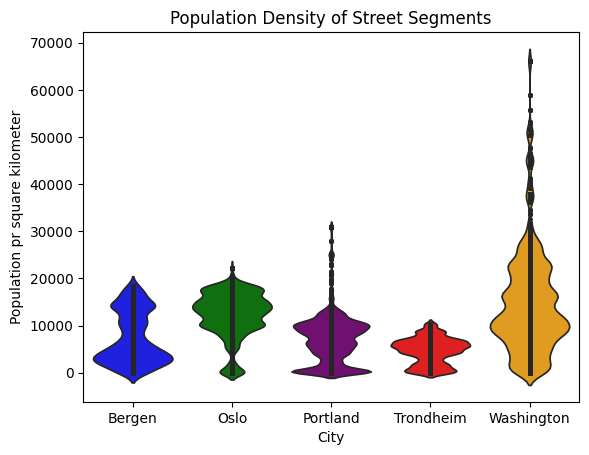

In [15]:
common_df = pd.DataFrame()
for city in city_dict:
    tmp = city_dict[city].feats.drop(columns = ['station', 'station_id'])
    tmp['sum'] = tmp.sum(axis = 1)
    tmp['city'] = city
    tmp['city'] = tmp['city'].str.capitalize()
    common_df = pd.concat([common_df, tmp])
common_df = common_df.sort_values(by = 'city', ascending = False)

smol = common_df[['price_per_sqm', 'city', 'population']].sort_values(by = 'city', ascending = True)
smol['population'] = smol['population'].apply(lambda x : x/0.61/0.61)

g = sns.violinplot(data = smol.query('population >= 0').reset_index(), y = 'population', x='city', common_norm = False, inner='point', hue='city', palette=city_color_map)
plt.ylabel('Population pr square kilometer')
plt.xlabel('City')
### sort x-axis

plt.title('Population Density of Street Segments')

plt.show()

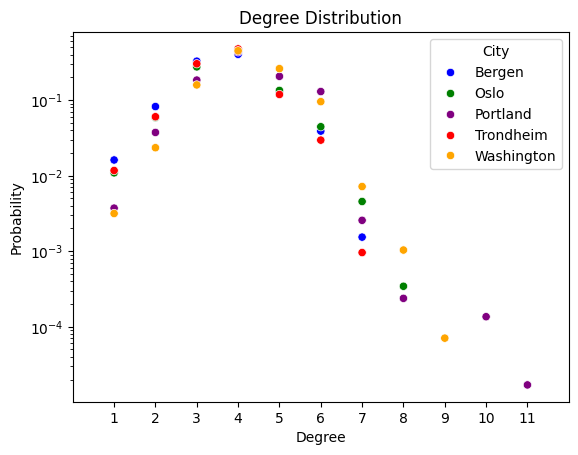

In [16]:
### plot degree distribution
degree_df = pd.DataFrame()

for city in city_dict:
    tmp = city_dict[city].lg.degree()
    tmp = pd.DataFrame(tmp, columns = ['node', 'degree'])
    tmp['City'] = city
    tmp['City'] = tmp['City'].str.capitalize()
    degree_df = pd.concat([degree_df, tmp])
degree_df = degree_df.sort_values(by = 'City', ascending = False)
degree_df.columns = [i.capitalize() for i in degree_df.columns]

degree_dist = degree_df.groupby(["Degree", "City"]).size().reset_index(name="count")
degree_dist["Probability"] = degree_dist.groupby("City")["count"].transform(lambda x: x / x.sum())

sns.scatterplot(data=degree_dist, x="Degree", y="Probability", hue="City", marker="o", palette=city_color_map)

plt.yscale('log')
plt.xticks(np.arange(1, degree_dist["Degree"].max() + 1, 1))
plt.xlim(0, 12)
plt.xlabel('Degree')
plt.ylabel('Probability')
plt.title('Degree Distribution')
# plt.legend(title="City")
plt.show()

In [ ]:
def create_rides_portland_gdf(df: pd.DataFrame, crs_in: int = 4326, crs_out: int = 3857) -> gpd.GeoDataFrame:
    df = df.copy()  # Create a copy to avoid changing the original DataFrame

    # Create a new DataFrame with necessary columns
    df_rides = df[
        [
            "StartDate",
            "EndDate",
            "StartHub",
            "StartLatitude",
            "StartLongitude",
            "EndHub",
            "EndLatitude",
            "EndLongitude",
            "month",
            "year",
        ]
    ].copy()  # copy to avoid warning

    df_rides.columns = [
        "started_at",
        "ended_at",
        "start_station_name",
        "start_station_latitude",
        "start_station_longitude",
        "end_station_name",
        "end_station_latitude",
        "end_station_longitude",
        "month",
        "year",
    ]

    # Create LineString objects
    df_rides.loc[:, "geometry"] = df_rides.apply(
        lambda row: LineString(
            [
                (row["start_station_longitude"], row["start_station_latitude"]),
                (row["end_station_longitude"], row["end_station_latitude"]),
            ]
        ),
        axis=1,
    )

    # Create GeoDataFrame
    gdf_rides = gpd.GeoDataFrame(df_rides, geometry="geometry", crs=crs_in)
    gdf_rides = gdf_rides.to_crs(epsg=crs_out)
    return gdf_rides